<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.1
scipy 0.19.1
pandas 0.20.3
matplotlib 2.0.2
sklearn 0.19.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.5.0


##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

plt.rcParams['figure.figsize'] = 16, 10

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [37]:
class SGDRegressor(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        w = np.zeros(X.shape[1])
        for t in range(self.n_iter):
            for i in range(X.shape[0]):
                x_i = X[i]
                y_i = y[i]
                w = w + self.eta *  np.dot(y_i - np.dot(w, x_i), x_i)
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, np.dot (X, w)))    
        self.w_ = self.weights_[self.mse_.index(min(self.mse_))]
        return self
    
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X, self.w_)            

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [38]:
data_demo = pd.read_csv('../data/weights_heights.csv')

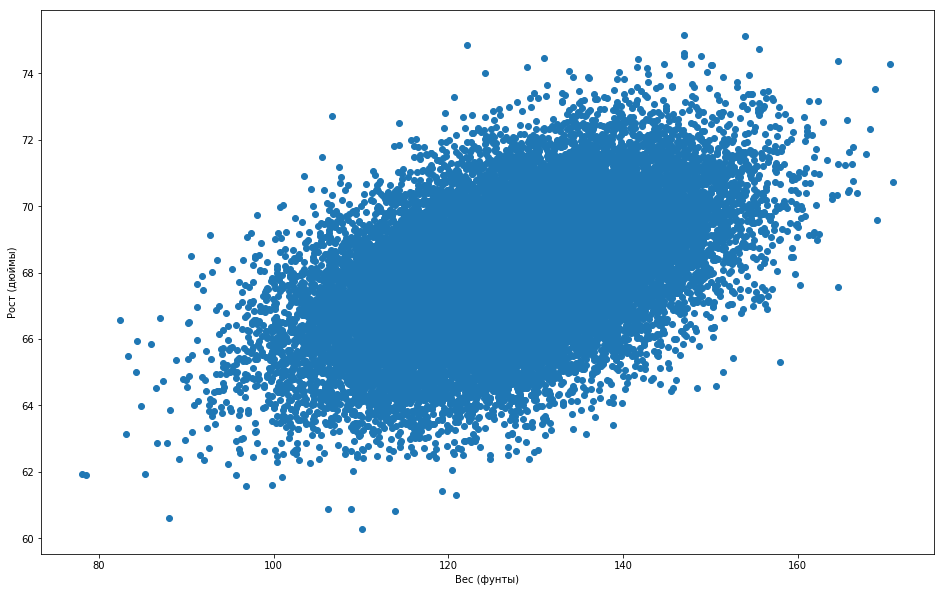

In [39]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [40]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [43]:
''' ВАШ КОД ЗДЕСЬ '''
regressor = SGDRegressor()
regressor.fit(X_train_scaled, y_train)

SGDRegressor(eta=0.001, n_iter=10)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

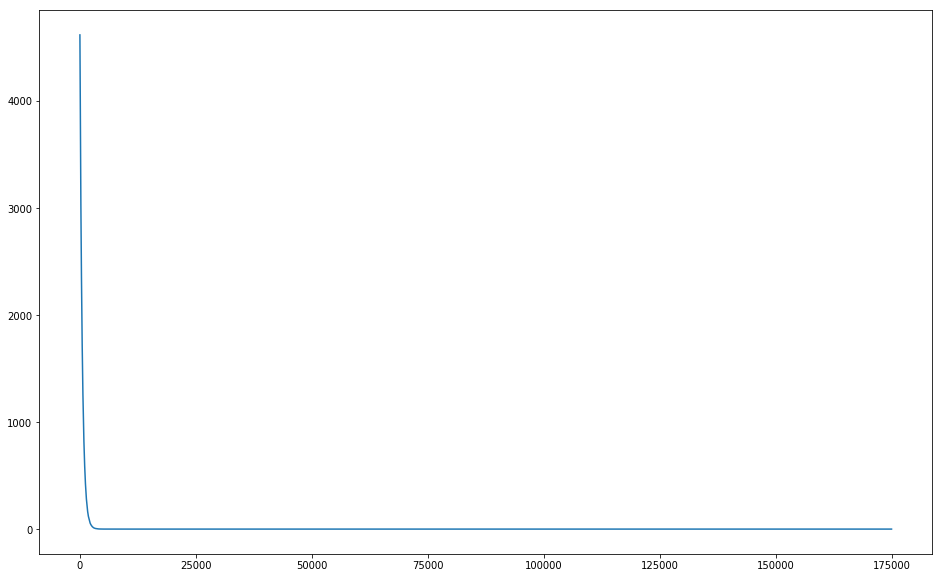

In [44]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(regressor.mse_)

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [45]:
''' ВАШ КОД ЗДЕСЬ '''
print(f"Min MSE: {min(regressor.mse_)}, best weights: {regressor.w_}")

Min MSE: 2.7151352406643627, best weights: [ 67.9898497    0.94447605]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

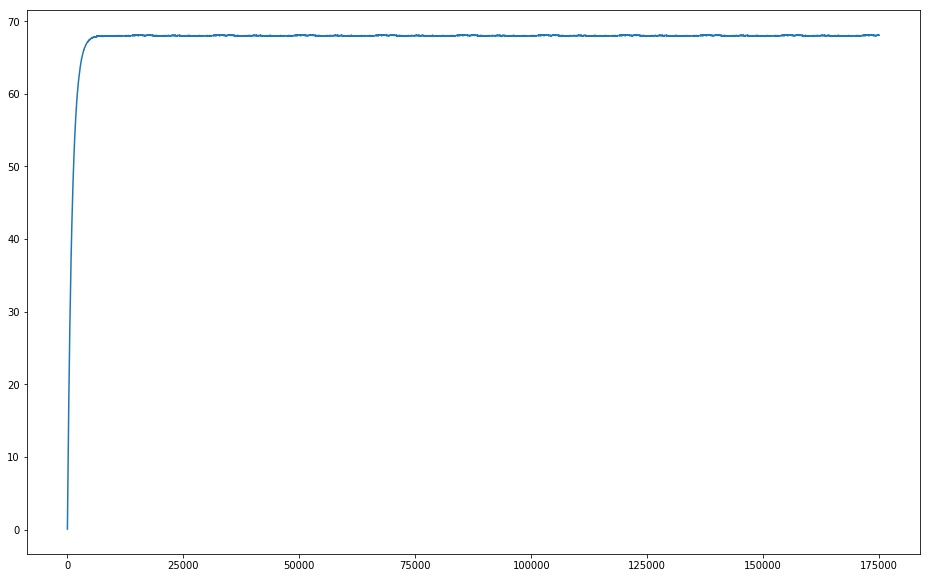

In [46]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot([x[0] for x in regressor.weights_])

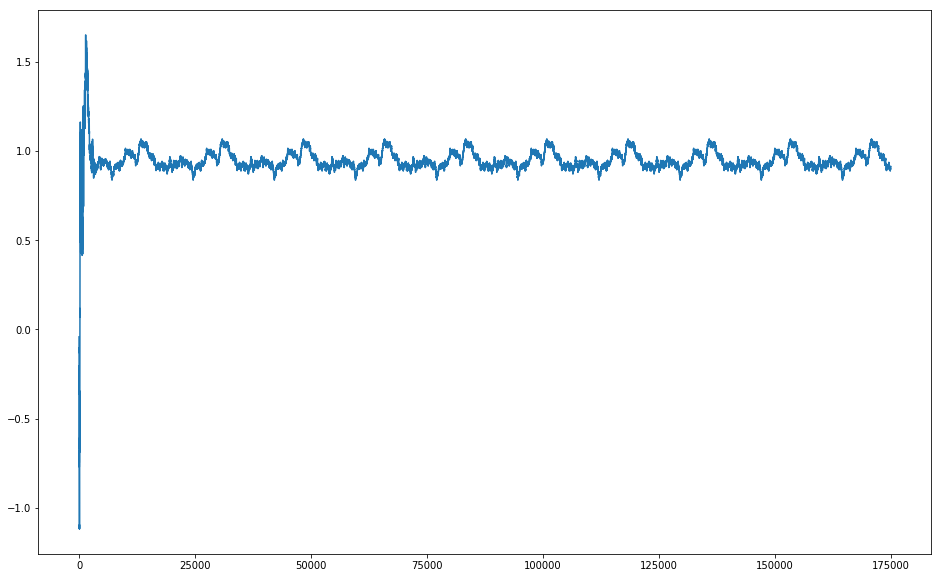

In [47]:
plt.plot([x[1] for x in regressor.weights_])

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [48]:
''' ВАШ КОД ЗДЕСЬ '''
y_pred = regressor.predict(X_valid_scaled)
mean_squared_error(y_valid, y_pred)

2.670868120703378

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [49]:
''' ВАШ КОД ЗДЕСЬ '''
regr_sk = LinearRegression()
regr_sk.fit(X_train_scaled, y_train)
y_pred_sk = regr_sk.predict(X_valid_scaled)
mean_squared_error(y_valid, y_pred_sk)

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - **5**

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - **$w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$ ** !!!
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [29]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))


def kronecker(w):
    w[0] = 0
    return w

In [67]:
class SGDClassifier(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, C, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        w = np.zeros(X.shape[1])
        for t in range(self.n_iter):
            for i in range(X.shape[0]):
                w = w + self.eta  * (self.C* y[i] * sigma( - y[i] * np.dot(w, X[i])) * X[i] - kronecker(w))
                self.weights_.append(w)
                self.loss_.append (log_loss( y , [-1 if p<0.5 else 1 for p in sigma(np.dot(X, w))]))
            
        self.w_ = self.weights_[self.loss_.index(min(self.loss_))]
        return self
    
    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigma(np.dot(X, self.w_))
    
    def predict(self, X):
        y = self.predict_proba(X)
        return [-1 if p<0.5 else 1 for p in y]

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [68]:
from sklearn.datasets import load_breast_cancer

In [69]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)


In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [72]:
''' ВАШ КОД ЗДЕСЬ '''
clf = SGDClassifier(C=1,eta=1e-3, n_iter=3).fit(X_train_scaled, y_train)

Постройте график изменения log_loss.

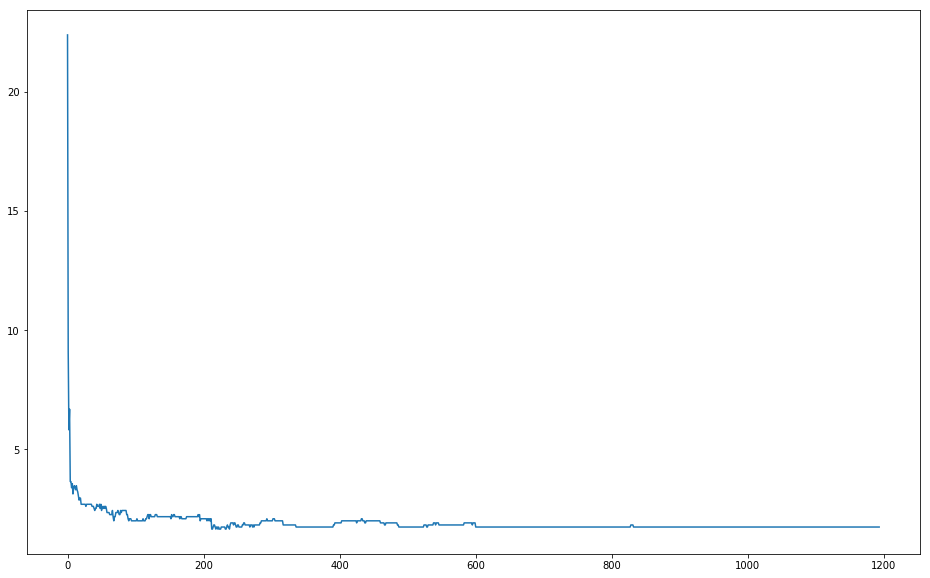

In [73]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(clf.loss_)

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [81]:
''' ВАШ КОД ЗДЕСЬ '''
clf = SGDClassifier(C=1000,eta=1e-3, n_iter=10).fit(X_train_scaled, y_train)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

In [82]:
clf.w_

array([ 0.        , -1.23558868, -1.66855549, -1.06590721, -2.06553866,
       -0.3376353 ,  1.98964101, -2.62924689, -2.74634536,  0.57681429,
        1.43987433, -3.12621912,  0.34255501, -1.75027669, -3.12694236,
       -0.67716971,  3.8006792 ,  0.08423422,  1.17193381, -0.93648783,
        1.46582428, -2.95561343, -3.17048184, -2.20548637, -3.5693235 ,
       -2.84673428,  0.68074703, -3.16385024, -1.17972238, -2.20194491,
       -1.35907592])

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - **compactness error**
 - worst fractal dimension

In [89]:
max_index = clf.w_[1:].argmax()
cancer.feature_names[max_index]

'compactness error'

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [90]:
''' ВАШ КОД ЗДЕСЬ '''
y_log = clf.predict(X_valid_scaled)
print(f"log_loss: {log_loss(y_valid, y_log)}, roc_auc: {roc_auc_score(y_valid, y_log)}")

log_loss: 1.0099244465747035, roc_auc: 0.9626676602086439


In [91]:
clf2 = LogisticRegression(random_state=17).fit(X_train_scaled,y_train)
y_l = clf2.predict(X_valid_scaled)
print(f"log_loss: {log_loss(y_valid, y_l)}, roc_auc: {roc_auc_score(y_valid, y_l)}")

log_loss: 0.8079432980664542, roc_auc: 0.9672131147540984


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [93]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [95]:
# поменяйте путь к файлу
reviews_train = load_files("../data/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [96]:
reviews_test = load_files("../data/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [97]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 25.5 s, sys: 392 ms, total: 25.9 s
Wall time: 26.4 s


In [98]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [99]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
regr = LogisticRegression(random_state=17, n_jobs=-1).fit(X_train, y_train)

/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU times: user 1min 17s, sys: 832 ms, total: 1min 18s
Wall time: 39.7 s


In [107]:
y_pred = regr.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.9582472128


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - **Реализован линейный SVM**
 - Реализована ранняя остановка во избежание переобучения
 - **Есть распараллеливание по процессорам**
 - **Можно обучать LASSO**
 - Поддерживается онлайн-обучение деревьев решений
 - **Поддерживается mini-batch подход (обновление весов по нескольким объектам сразу, а не по одному)**


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [109]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
sgd_logreg = SGDClassifier(loss="log", random_state=17, n_jobs=-1, n_iter=100)
sgd_logreg.fit(X_train, y_train)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


CPU times: user 7.88 s, sys: 20 ms, total: 7.9 s
Wall time: 7.71 s


In [110]:
roc_auc_score(y_test, sgd_logreg.predict_proba(X_test)[:,1])

0.95728946560000006

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - **3**
 - 4
 - 5